# Goal: Visualize Learned Convolutions of AlexNet

In the previous demo, we explicitly set the weights of different convolution kernels to visualize their effects on MNIST images. In deep learning, however, the weights of the kernels are learned via backpropagation and SGD. In this demo, we will use the `torchvision` library to import a trained version of [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) and visualize the first layer's learned convolutions and examine feature maps after passing an image through the first layer. AlexNet is used for image classification tasks.

Some sources:
- [CS231n - Visualizing what ConvNets learn](https://cs231n.github.io/understanding-cnn/)

## Generalizing the 2-D Convolution
First, let's recap the convolution operation and extend our definition from the last demo to first support multiple input channels and then support multiple output channels. I find the figures in [Dive](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html#the-cross-correlation-operation) Into [Deep](https://d2l.ai/chapter_convolutional-neural-networks/channels.html#fig-conv-multi-in) [Learning](https://d2l.ai/chapter_convolutional-neural-networks/channels.html#fig-conv-1x1) helpful (reproduced here). 

### Single-Input Channel to Single-Output Channel
In this simplest case, the input image has a single channel (for example, grayscale images) and so does the output. To produce an output pixel, we perform an element-wise multiplication of the filter weights with a patch of the image and take the sum.

![](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/correlation.svg)
### Multiple-Input Channel to Single-Output Channel
From here, we can extend to multiple input channels (in this case, our image now has two input channels). We have a kernel for each channel dimension. To produce an output pixel, we perform the convolution operation per channel and the sum the resulting value from each channel.

![](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/conv-multi-in.svg)
### Multiple-Input Channel to Multiple-Output Channel
To produce multiple output channels, we now have a set of kernels (shown with different colors below) for each output channel.

![](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/conv-1x1.svg)

The first gif on this website shows an animation of the multiple-input, multiple-output case: https://animatedai.github.io/

## Imports
Let's start by importing our favorite packages.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(100)

from PIL import Image

import torchsummary

## Plotting Function
We will use these two functions to plot our convolution filters and feature maps later on in the notebook.

In [2]:
## produces an 8 by 8 set of convolution kernels. 
def plot_first_layer_filters(conv_layer, nrows=8, ncols=8):
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
    plt.axis('off')
    idx = 0
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            curr_filter = conv_layer.weight.data[idx].permute(1,2,0).clone() # (C, H, W) -> (H, W, C)
            axs[i,j].set_axis_off()
            axs[i,j].imshow(curr_filter, vmin=curr_filter.min(), vmax=curr_filter.max()) # plot kernel
            idx += 1

## produces an 8 by 8 set of feature maps after passing an image through the first conv layer
def plot_first_layer_activations(output):
    fig, axs = plt.subplots(8,8, figsize=(15, 15))
    plt.axis('off')
    idx = 0
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            curr_activation = output[idx].clone()
            axs[i,j].set_axis_off()
            axs[i,j].imshow(curr_activation)
            idx += 1

## Loading AlexNet
The library [`torchvision`](https://pytorch.org/vision/stable/models.html#classification) has many classification models built-in and provides the weights for models trained on the ImageNet dataset (2012 version). This dataset contains RGB images of size $224 \times 224 \times 3$ which are classified into one of 1000 classes. Let's import [torchvision's AlexNet](https://pytorch.org/vision/stable/models/generated/torchvision.models.alexnet.html#torchvision.models.alexnet). If we pass in a `weights` parameters, the trained weights will also be downloaded. We will have two instances of AlexNet: one that has not been trained and one that has been trained.

In [5]:
alexnet = torchvision.models.alexnet() # untrained
alexnet_pretrained = torchvision.models.alexnet(weights='DEFAULT') # trained

Let's print out the network. Note that the network is subtly different from the one proposed in the original paper; PyTorch implements a modified AlexNet from [this paper](https://arxiv.org/abs/1404.5997).

In [7]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see it consists of two parts: a feature extractor (built up by convolution layers) and a classfier (built using fully connected layers). Let's use the `torchsummary` package to see what happens to the *shape* of the image as it is processed through the network.

In [8]:
torchsummary.summary(alexnet, (3, 224, 224), 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 55, 55]          23,296
              ReLU-2            [1, 64, 55, 55]               0
         MaxPool2d-3            [1, 64, 27, 27]               0
            Conv2d-4           [1, 192, 27, 27]         307,392
              ReLU-5           [1, 192, 27, 27]               0
         MaxPool2d-6           [1, 192, 13, 13]               0
            Conv2d-7           [1, 384, 13, 13]         663,936
              ReLU-8           [1, 384, 13, 13]               0
            Conv2d-9           [1, 256, 13, 13]         884,992
             ReLU-10           [1, 256, 13, 13]               0
           Conv2d-11           [1, 256, 13, 13]         590,080
             ReLU-12           [1, 256, 13, 13]               0
        MaxPool2d-13             [1, 256, 6, 6]               0
AdaptiveAvgPool2d-14             [1, 25

Our image starts out as a $224 \times 224 \times 3$ images and is transformed to a vector of length $1000$ where each element represents the likelihood that the input image belonged to that class. During the convolution portion of the image, note that the image's height and width dimension decrease (for example from $224$ to $55$ to $27$ and so on) while the number of channels increases (from $3$ to $64$ to $192$ and so forth).

We will see the same network if we print out the already-trained version.

In [9]:
print(alexnet_pretrained)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Let's focus in on the first convolution layer. It's written above as:

```python
(0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
```

Check out the [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) documentation to see what each of these parameters means. Let's print out the shape of the trainable parameters tensor. This tensor consists of all the kernels in the first convolution layer. We can directly index the `features` portion of AlexNet.

In [11]:
print(alexnet.features[0].weight.shape)

torch.Size([64, 3, 11, 11])


- number of output channels: 64
- number of input channels: 3
- kernel height: 11
- kernel width: 11

## Plotting Learned Convolutions

So, the first convolution corresponds to the multiple-input channel, multiple-output channel case shown at the beginning of this notebook. Now, let's use our plotting function to plot each kernel **for the network that was already trained**. We will be plotting $64$ kernels (each one corresponds to an output channel). 

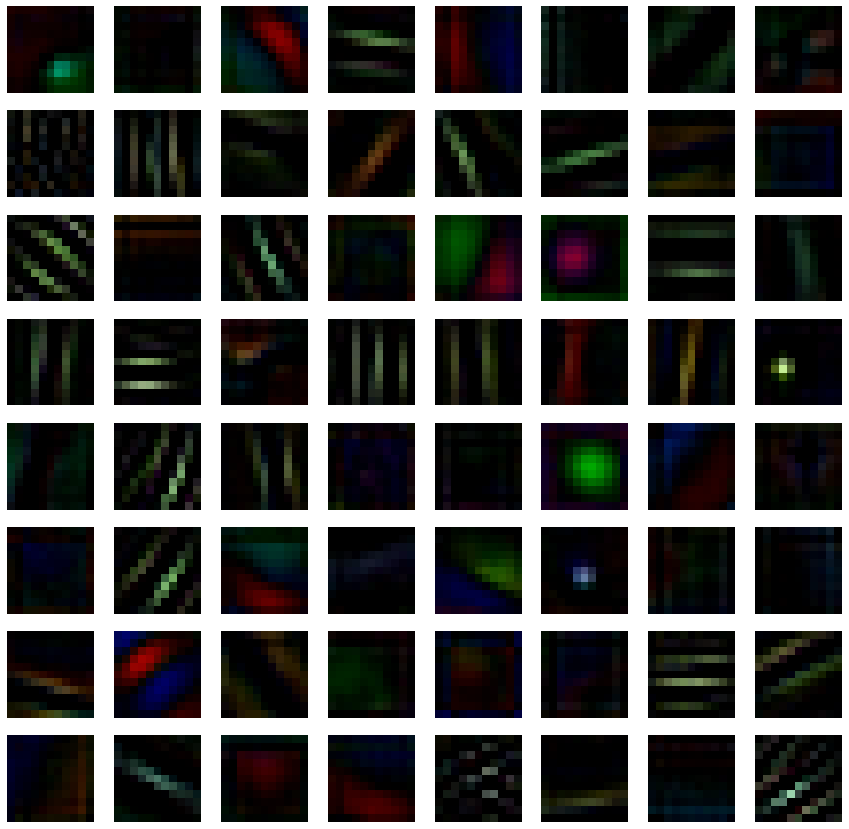

In [13]:
trained_conv_layer = alexnet_pretrained.features[0]
plot_first_layer_filters(trained_conv_layer, nrows=8, ncols=8)

As we can see, each of these *learned kernels* has learned a different set of weights! Some are more concentrated to one region of the $11 \times 11$ kernel while others look similar to the horizontal edge detector we implemented in the previous notebook. 

## Plotting Randomly Initialized Kernels
Let's plot the same kernels, except for the network that **has not been trained**. 

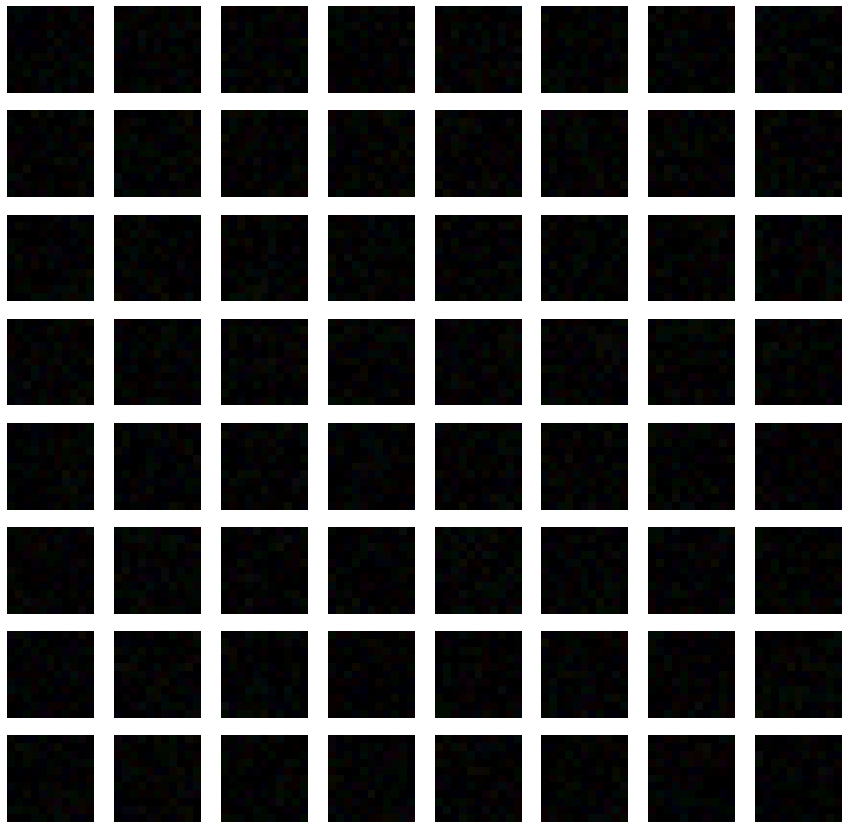

In [15]:
untrained_conv_layer = alexnet.features[0]
plot_first_layer_filters(untrained_conv_layer, nrows=8, ncols=8)

Nothing too interesting here; the kernels have only been initialized to small random values but they haven't been trained yet! Through an optimizer (such as SGD) and backpropagation, we went from these kernels to the ones previously plotted. 

## Plotting the Output Feature Map

Let's take one image from ImageNet (an image of a cat) `n02124075_1.JPEG`, although you could try a different image. And run it through the first convolution layer to see what sort of feature maps are extracted. We will first transform this image to a Torch Tensor and then resize this image to work with AlexNet and plot it.

In [21]:
img = Image.open("dl_demos/imgs/n02124075_1.JPEG")
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
img = transform(img)
print(img.shape)

torch.Size([3, 224, 224])


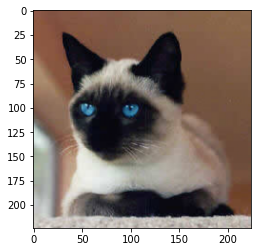

In [26]:
plt.imshow(img.permute(1,2,0)) ## Permute (Channels, Height, Width) -> (Height, Width, Channels)

Let's forward propagate through the first layer and plot the images. We can directly use the `forward` method of the convolution layer (a bit hacky, but it works for what we are trying to show). 

In [27]:
out = trained_conv_layer(img).detach()
print(out.shape)

torch.Size([64, 55, 55])


Our output feature map shape is $64 \times 55 \times 55$. Our number of channels has increased from $3$ to $64$ and our height (and width) has decreased from $224$ to $55$. This is in agreement with what `torchsummary` told us earlier. Let's now plot these post-convolution feature maps.

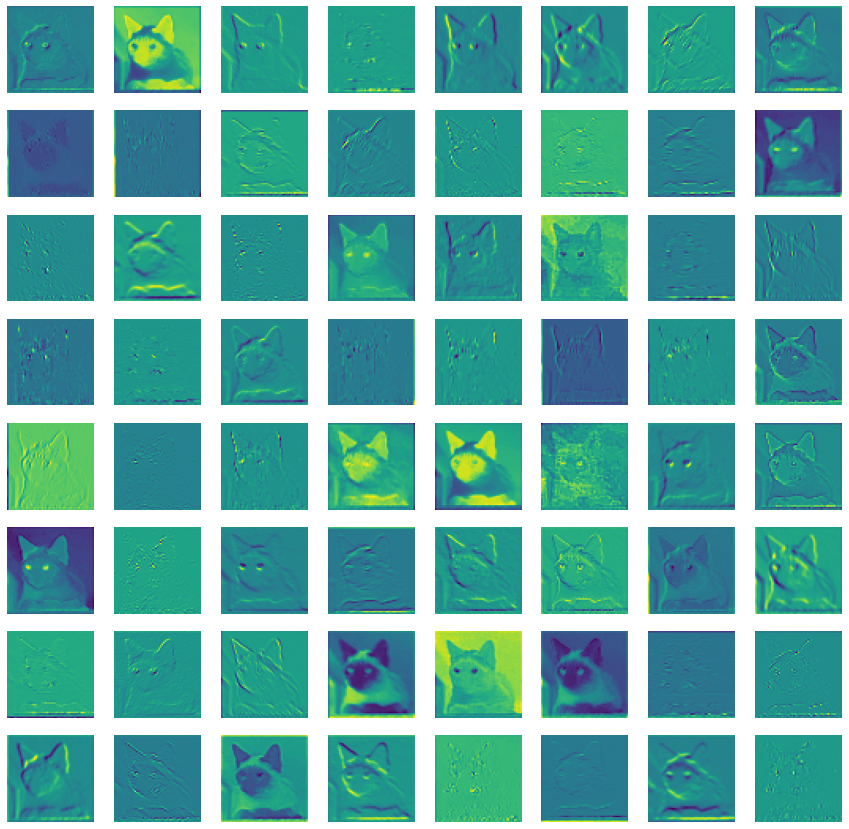

In [28]:
plot_first_layer_activations(out)

As we can see, each output channel has extracted different information from the input image. Some channels have picked up on edges while others are more blobby. And that's it! Hopefully this notebook sheds some light on interpretability in Convolutional Neural Networks and I would highly recommend checking out [https://cs231n.github.io/understanding-cnn/](https://cs231n.github.io/understanding-cnn/) for a more extensive review of intepreting CNNs. 